In [60]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

Physical devices cannot be modified after being initialized


In [3]:
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

In [4]:
(X_train,y_train),(X_test,y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

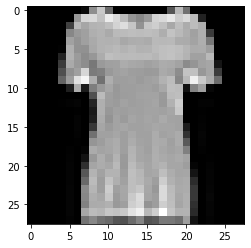

In [11]:
plt.imshow(X_train[10], cmap='gray')

In [61]:
y_train = to_categorical(y_train)
#y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

### 의류 분류 모델 만들기 실습
- 1. y data 원 핫 인코딩 & x data reshape해서 4차원으로 만들기 -> (60000,28,28,1)
- 2. 직접 모델 쌓기 or 전이학습
- 3. input_shape 입력 고려
- 4. 출력층 Dense 개수와 활성화 함수 고려
- 5. loss, optimizer 고려
- 6. 조기학습중단, 모델저장
- 7. fit or fit_generator (배치사이즈 조절을 통해 OOM 나오지 않도록)
- 8. test 데이터 evaluate 점수 및 사용한 모델의 파라미터 수 카톡방에 올리기

### 데이터 3채널로 바꾸기 for Xception
- 흑백 채널을 복제를해서 3채널로 확장
- 이미지 크기를 28 x 28에서 변경

In [12]:
# !pip install tqdm

In [20]:
from tqdm import tqdm
from PIL import Image
import numpy as np

In [28]:
resize_list = []
for i in tqdm(range(len(X_train))) : # 0~59999
    resize_img = Image.fromarray(X_train[i]).resize((244,244))
    resize_list.append(np.array(resize_img))

100%|██████████| 60000/60000 [00:17<00:00, 3381.90it/s]


In [31]:
X_train_resized = np.array(resize_list)
X_train_resized.shape

(60000, 244, 244)

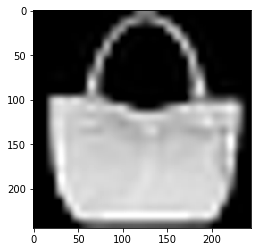

In [32]:
plt.imshow(X_train_resized[100],cmap='gray')

In [35]:
X_train_resized = X_train_resized.reshape(60000,244,244,1)

In [36]:
X_train_resized = np.repeat(X_train_resized, 3, axis=3)

In [37]:
X_train_resized.shape

(60000, 244, 244, 3)

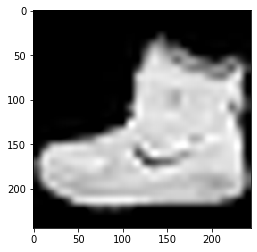

In [40]:
plt.imshow(X_train_resized[0])

### 훈련 셋과 검증 셋으로 분리

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train,X_val,y_train,y_val = train_test_split(X_train_resized,y_train,
                                              test_size=0.3)

In [43]:
from tensorflow.keras.applications import Xception

In [63]:
pre_trained_model = Xception(include_top=False, # False는 Dense층 제외 
                            weights='imagenet', # 사전학습된 가중치 로드
                            input_shape=(244,244,3))
pre_trained_model.trainable = True

In [64]:
myXception_model = Sequential()
myXception_model.add(pre_trained_model)
myXception_model.add(Flatten())
myXception_model.add(Dense(512,activation='relu'))
myXception_model.add(Dense(10,activation='softmax'))

In [65]:
myXception_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                     metrics=['accuracy'])

In [66]:
myXception_model.fit(X_train,y_train,
                     batch_size=16,
                    epochs=50,
                    validation_data=(X_val,y_val))

Train on 42000 samples, validate on 18000 samples
Epoch 1/50
42000/42000 [==============================] - 734s 17ms/sample - loss: 0.2994 - accuracy: 0.8968 - val_loss: 0.1957 - val_accuracy: 0.9282
Epoch 2/50
42000/42000 [==============================] - 742s 18ms/sample - loss: 0.1720 - accuracy: 0.9400 - val_loss: 0.2529 - val_accuracy: 0.9145
Epoch 3/50
42000/42000 [==============================] - 737s 18ms/sample - loss: 0.1196 - accuracy: 0.9575 - val_loss: 0.2134 - val_accuracy: 0.9322
Epoch 4/50
42000/42000 [==============================] - 735s 18ms/sample - loss: 0.0890 - accuracy: 0.9689 - val_loss: 0.2295 - val_accuracy: 0.9376
Epoch 5/50
42000/42000 [==============================] - 740s 18ms/sample - loss: 0.0717 - accuracy: 0.9754 - val_loss: 0.1998 - val_accuracy: 0.9433
Epoch 6/50
42000/42000 [==============================] - 741s 18ms/sample - loss: 0.0523 - accuracy: 0.9816 - val_loss: 0.2329 - val_accuracy: 0.9406
Epoch 7/50
42000/42000 [====================

KeyboardInterrupt: 